# Machine learning pipeline for modelling fraction of precipitation in different intensity bands

This notebook is designed to be run in AzureML 

### Import relevant libraries

In [1]:
import pathlib
import os
import datetime
import json

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# %load_ext tensorboard

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv1D, concatenate
from tensorflow.keras.layers import ZeroPadding1D, Reshape, Input, Dropout, PReLU
from tensorflow.keras.models import Sequential, Model

In [5]:
import prd_pipeline

In [6]:
pathlib.Path.cwd().parent

PosixPath('/mnt/batch/tasks/shared/LS_root/mounts/clusters/prd-ml-fractions/code/Users/hannah.brown/precip_rediagnosis')

Set up MLops for experiment tracking in AzureML

In [7]:
import mlflow
mlflow.tensorflow.autolog()

2022/10/25 13:39:37 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


In [8]:
import azureml.core
from azureml.core import Workspace, Datastore, Dataset
from azureml.core import Experiment

prd_ws = Workspace.from_config()

In [9]:
mlflow.set_tracking_uri(prd_ws.get_mlflow_tracking_uri())

### Load and preprocess data

In [10]:
prd_prefix = 'prd'
merged_prefix = prd_prefix + '_merged'
csv_file_suffix = 'csv'

In [11]:
bands = {
    '0.0':[0, 0.01],
    '0.25':[0.01, 0.5], 
    '2.5': [0.5, 4], 
    '7.0':[4, 10], 
    '10.0':[10,220]
}

In [12]:
intensity_band_template = '{source}_fraction_in_band_instant_{band_centre}'

In [13]:
target_parameter = [intensity_band_template.format(source='radar', band_centre=threshold) for threshold in bands.keys()]
nwp_comparison = [intensity_band_template.format(source='mogrepsg', band_centre=threshold) for threshold in bands.keys()]

profile_features = ['air_temperature', 'relative_humidity', 'wind_speed', 'wind_from_direction', 'cloud_volume_fraction'] #'air_pressure',
single_lvl_features = []#'thickness_of_rainfall_amount', 'surface_altitude', 'air_pressure_at_sea_level', 'cloud_area_fraction'

In [14]:
feature_dict = {
    'profile': profile_features,
    'single_level': single_lvl_features,
    'target': target_parameter,
    'nwp': nwp_comparison, 
    'metadata': ['time', 'realization', 'latitude', 'longitude']
} 

In [15]:
load_all = True

In [16]:
if load_all:
    prd_azml_dataset_name = 'prd_merged_all_events_files'
else:
    prd_azml_dataset_name = 'prd_merged_202110_nswws_amber_oct_files'


In [17]:
prd_azml_dataset = azureml.core.Dataset.get_by_name(prd_ws, name=prd_azml_dataset_name)

In [18]:
with prd_azml_dataset.mount() as prd_mount:
    print('loading all data')
    prd_path_list = [p1 for p1 in pathlib.Path(prd_mount.mount_point).rglob('*csv')]
    test_scenario = pd.read_csv(prd_path_list[-1])
    # prd_path_list = prd_path_list[:-1]
    merged_df = pd.concat([pd.read_csv(p1) for p1 in prd_path_list])

Not mounting as a volume: ArgumentError(InvalidArgument { argument: "arguments.path", expected: "Glob patterns inside the path are not supported by the volume mount.Path must be a direct path to the file or folder, or end with '/**' or '/**/*' to match the entire content of the volume.", actual: "REDACTED" }). 
Falling back to dataflow mount.
loading all data


### Calculate NWP probabilities of falling in each intensity bands - <i> to be moved into data prep </i>

In [19]:
def calc_nwp_probabilities(data, lower_bound, upper_bound):
    return ((data>=lower_bound) & (data<upper_bound)).sum()/data.shape[0]

In [20]:
# %%timeit
nwp_fractions = [
    merged_df.groupby(['latitude', 'longitude', 'time'])[['rainfall_rate']].apply(
        lambda x: calc_nwp_probabilities(x, lower_bound, upper_bound)).rename(columns={'rainfall_rate':intensity_band_template.format(source='mogrepsg', band_centre=intensity_band)})
    for intensity_band, [lower_bound, upper_bound] in bands.items()]
nwp_prob_df = pd.concat(nwp_fractions, axis=1)
merged_df = pd.merge(merged_df, nwp_prob_df, left_on=['latitude', 'longitude', 'time'], right_index=True)

In [21]:
merged_df.head()

,realization,latitude,longitude,forecast_period,forecast_reference_time,time,cloud_area_fraction,surface_altitude,air_pressure_at_sea_level,rainfall_rate,...,radar_fraction_in_band_instant_0.0,radar_fraction_in_band_instant_0.25,radar_fraction_in_band_instant_2.5,radar_fraction_in_band_instant_7.0,radar_fraction_in_band_instant_10.0,mogrepsg_fraction_in_band_instant_0.0,mogrepsg_fraction_in_band_instant_0.25,mogrepsg_fraction_in_band_instant_2.5,mogrepsg_fraction_in_band_instant_7.0,mogrepsg_fraction_in_band_instant_10.0
0,0,49.40625,-5.484375,0 days 06:00:00,2020-02-07 12:00:00,2020-02-07 18:00:00,0.984375,0.0,101050.0,0.000000,...,0.463529,0.515294,0.025882,0.0,0.0,0.666667,0.222222,0.111111,0.0,0.0
1,1,49.40625,-5.484375,0 days 06:00:00,2020-02-07 12:00:00,2020-02-07 18:00:00,1.000000,0.0,101036.0,0.536442,...,0.463529,0.515294,0.025882,0.0,0.0,0.666667,0.222222,0.111111,0.0,0.0
2,2,49.40625,-5.484375,0 days 06:00:00,2020-02-07 12:00:00,2020-02-07 18:00:00,0.984375,0.0,101104.0,0.000000,...,0.463529,0.515294,0.025882,0.0,0.0,0.666667,0.222222,0.111111,0.0,0.0
3,3,49.40625,-5.484375,0 days 06:00:00,2020-02-07 12:00:00,2020-02-07 18:00:00,0.843750,0.0,101005.0,0.000000,...,0.463529,0.515294,0.025882,0.0,0.0,0.666667,0.222222,0.111111,0.0,0.0
4,4,49.40625,-5.484375,0 days 06:00:00,2020-02-07 12:00:00,2020-02-07 18:00:00,1.000000,0.0,101038.0,0.000000,...,0.463529,0.515294,0.025882,0.0,0.0,0.666667,0.222222,0.111111,0.0,0.0


### Calculate u and v wind fields and add column to dataset <i>- to be moved into data prep </i>

Adding columns with u and v wind fields

In [ ]:
# import math

# wdir_columns = prd_pipeline.get_profile_columns(['wind_from_direction'], merged_df.columns)
# ws_columns = prd_pipeline.get_profile_columns(['wind_speed'], merged_df.columns)

# for (wdir, ws) in zip(wdir_columns, ws_columns):
#     height_level = wdir.split('_')[-1]
#     print(height_level)
#     merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
#         lambda x: math.sin(math.radians(270 - x))) * merged_df[f'wind_speed_{height_level}']
#     merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
#         lambda x: math.cos(math.radians(270 - x))) * merged_df[f'wind_speed_{height_level}']

To check the u and v wind conversion, we convert back from u and v wind fields to wind speed and direction and compare this to wind speed and direction in the dataset. This test currently fails as there are a few data points with wind speeds of zero. May be worth some investigation into whether these zero are spurious or not, but perhaps easiest at this stage to filter out zero values. 

In [ ]:
# # test for u and v wind conversion
# for (wdir, ws) in zip(wdir_columns, ws_columns):
#     height_level = wdir.split('_')[-1]
#     print(height_level)
#     print(merged_df[(merged_df[f'wind_from_direction_{height_level}'] != np.round(np.rad2deg(np.arctan2(merged_df[f'v_wind_{height_level}'], merged_df[f'u_wind_{height_level}'])) + 180, 4))][[f'wind_from_direction_{height_level}', f'wind_speed_{height_level}']])
#     merged_df = merged_df[merged_df[ws] != 0]
    
#     assert (merged_df[f'wind_speed_{height_level}'] == np.round(np.sqrt(merged_df[f'u_wind_{height_level}']**2 + merged_df[f'v_wind_{height_level}']**2),4)).all()
#     assert (merged_df[f'wind_from_direction_{height_level}'] == np.round(np.rad2deg(np.arctan2(merged_df[f'v_wind_{height_level}'], merged_df[f'u_wind_{height_level}'])) + 180, 4)).all()

### Data pre-processing

Split train, test and validate datasets

In [22]:
test_fraction=0.2
df_train, df_test = prd_pipeline.random_time_space_sample(merged_df, test_fraction=test_fraction, random_state=np.random.RandomState(), sampling_columns = ['time', 'latitude', 'longitude'])
data_splits, data_dims_dict = prd_pipeline.preprocess_data(df_train, feature_dict, test_fraction=test_fraction/(1-test_fraction))

target has dims: 5
dropping smallest bin: radar_fraction_in_band_instant_0.0
getting profile columns
{'nprof_features': 5, 'nheights': 33, 'nsinglvl_features': 0, 'nbands': 5}


### Plot pie charts of average fractions in bands

Make a copy of the training dataset and add a column which contains the label for the intensity band with the highest fraction

In [ ]:
y_train_copy = data_splits['y_train'].copy().reset_index(drop=True)
y_train_copy['max_bin'] = y_train_copy.idxmax(axis=1)
y_train_copy[y_train_copy['max_bin']==feature_dict['target'][-1]]

Plot a pie chart of counts of the different intensity bands having highest fraction

In [ ]:
avg_df = pd.DataFrame({'Counts': y_train_copy['max_bin'].value_counts()})
avg_df.plot.pie(subplots=True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.1))
plt.title('Intensity band with highest fraction')
plt.show()

In [ ]:
def pie_chart_mean_fractions_in_bands(df, title):
    """Calculates the average values of a pandas series provided and produces a pie chart"""
    avg_df = pd.DataFrame({'Average': df.mean()})
    avg_df.plot.pie(subplots=True)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.1))
    plt.title(title)
    plt.show()

Produce pie chart for the average fraction in each intensity band for the train, test and validate datasets

In [ ]:
pie_chart_mean_fractions_in_bands(data_splits['y_train'], title='Average fraction in each intensity band - train dataset')

In [ ]:
pie_chart_mean_fractions_in_bands(data_splits['y_val'], title='Average fraction in each intensity band - validate dataset')

In [ ]:
# pie_chart_mean_fractions_in_bands(df_test[target_parameter], title='Average fraction in each intensity band - test dataset')

In [ ]:
data_splits['y_train'].boxplot(rot=90)

In [ ]:
data_splits['nwp_val'].boxplot(rot=90)

In [ ]:
data_splits['y_val'].boxplot(rot=90)

In [ ]:
df_test[target_parameter].boxplot(rot=90)

For each intensity band, select a subset which contains datapoint where the highest fraction falls into that intensity band, then produce the pie chart showing this average fraction in each intensity band. This allows us to see whether on average when a band has highest fraction whether it is marginally highest or is much higher than fractions of other bands.

In [ ]:
# y_train_copy = y_train_copy.reset_index(drop=True)
# for col in y_train_copy.columns[:-1]:
#     subset = y_train_copy[y_train_copy['max_bin']==col]
#     pie_chart_mean_fractions_in_bands(subset, title=f'Average fraction in intensity band \n highest frequency band {col} (nsamples = {len(subset)})')
#     plt.show()

### Class imbalance

Calculate weights to input when fitting model, which is used for weighting the loss function in the model training.

In [ ]:
y_train_copy['max_bin'].value_counts()

In [ ]:
# # weights = 1 / (y_train_copy['max_bin'].value_counts() / y_train_copy.shape[0]) / 4
# weights = 1 / data_splits['y_train'].mean() / 100
# weights = weights.reset_index(drop=True).to_dict()
# weights

Resample data to create more uniform distribution within the training data

In [ ]:
# nsamples = len(y_train_copy)//len(y_train_copy.columns)
# print('n samples =', nsamples)

# y_train = pd.DataFrame()

# y_train_copy = y_train_copy.reset_index(drop=True)

# for col in y_train_copy.columns[0:-1]:
#     print(col)
#     ids = y_train_copy[y_train_copy['max_bin']==col].index
#     print(ids.shape)
#     if len(ids)>0:
#         choices = np.random.choice(ids, nsamples)
#         y_train = pd.concat([y_train, y_train_copy.loc[choices]])
#         try: 
#             X_train = np.concatenate([X_train, data_splits['X_train'][choices]])
#         except NameError:
#             X_train = data_splits['X_train'][choices]

# cols = data_splits['y_train'].columns
# plt.plot(data_splits['y_train'].sum(axis=0), label='original data')
# plt.plot(y_train[cols].sum(axis=0), label='resampled data')
# plt.legend()
# plt.show()

# y_train = y_train.drop(columns=['max_bin'])

# data_splits['X_train'] = X_train
# data_splits['y_train'] = y_train
# data_dims_dict['nbands'] = data_splits['y_train'].shapey_train_copy

## Run experiment

Here we actually run the training and evaluation. All parameters and the output model will be saved through ML Flow, and we can track training stats through tensorboard.

In [23]:
exp_name='prd_fraction_models_mlflow'
exp1 = mlflow.create_experiment(exp_name)
exp1

'27014deb-848c-4241-966e-55b80a0c8ed4'

In [24]:
exp1 = mlflow.get_experiment(exp1)
exp1

<Experiment: artifact_location='', experiment_id='27014deb-848c-4241-966e-55b80a0c8ed4', lifecycle_stage='active', name='prd_fraction_models_mlflow', tags={}>

In [25]:
hyperparameter_dict = {
    'epochs': 10, 
    'learning_rate': 0.001, 
    'batch_size': 64, 
    # 'class_weights': weights, 
    'loss': tf.keras.losses.KLDivergence()
}

In [26]:
with mlflow.start_run(experiment_id=exp1.experiment_id) as current_run:
    mlflow.log_param('features', feature_dict['profile'] + feature_dict['single_level'])    
    model = prd_pipeline.build_model(**data_dims_dict)
    model.summary()
    model, history = prd_pipeline.train_model(model, data_splits, hyperparameter_dict, log_dir='./logs')

2022-10-25 13:54:19.669912: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-10-25 13:54:20.340706: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-25 13:54:20.340780: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (prd-ml-fractions): /proc/driver/nvidia/version does not exist
2022-10-25 13:54:20.343305: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-10-25 13:54:20.352239: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2593905000 Hz
2022-10-25 13:54:20.354295: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f7d84000b60 initialized for platform Host (this does not guarantee that XLA will be used). Devices:

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
profile_input (InputLayer)      [(None, 33, 5)]      0                                            
__________________________________________________________________________________________________
zero_padding1d (ZeroPadding1D)  (None, 35, 5)        0           profile_input[0][0]              
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 33, 32)       480         zero_padding1d[0][0]             
__________________________________________________________________________________________________
zero_padding1d_1 (ZeroPadding1D (None, 35, 32)       0           conv1d[0][0]                     
______________________________________________________________________________________________

2022-10-25 13:54:24.932273: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.


   29/12363 [..............................] - ETA: 6:34 - loss: 0.5855 - accuracy: 0.5657

2022-10-25 13:54:25.055516: I tensorflow/core/profiler/rpc/client/save_profile.cc:168] Creating directory: ./logs/train/plugins/profile/2022_10_25_13_54_24
2022-10-25 13:54:25.252013: I tensorflow/core/profiler/rpc/client/save_profile.cc:174] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2022_10_25_13_54_24/prd-ml-fractions.trace.json.gz
2022-10-25 13:54:25.252909: I tensorflow/core/profiler/utils/event_span.cc:288] Generation of step-events took 0.025 ms

2022-10-25 13:54:25.702122: I tensorflow/python/profiler/internal/profiler_wrapper.cc:87] Creating directory: ./logs/train/plugins/profile/2022_10_25_13_54_24Dumped tool data for overview_page.pb to ./logs/train/plugins/profile/2022_10_25_13_54_24/prd-ml-fractions.overview_page.pb
Dumped tool data for input_pipeline.pb to ./logs/train/plugins/profile/2022_10_25_13_54_24/prd-ml-fractions.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to ./logs/train/plugins/profile/2022_10_25_13_54_24/prd-ml-fr

12363/12363 [==============================] - 63s 5ms/step - loss: 0.4304 - accuracy: 0.6444 - val_loss: 0.4129 - val_accuracy: 0.6536
Epoch 2/10
12363/12363 [==============================] - 59s 5ms/step - loss: 0.3916 - accuracy: 0.6701 - val_loss: 0.3995 - val_accuracy: 0.6619
Epoch 3/10
12363/12363 [==============================] - 61s 5ms/step - loss: 0.3746 - accuracy: 0.6802 - val_loss: 0.3915 - val_accuracy: 0.6676
Epoch 4/10
12363/12363 [==============================] - 60s 5ms/step - loss: 0.3633 - accuracy: 0.6877 - val_loss: 0.3874 - val_accuracy: 0.6709
Epoch 5/10
12363/12363 [==============================] - 60s 5ms/step - loss: 0.3549 - accuracy: 0.6928 - val_loss: 0.3841 - val_accuracy: 0.6724
Epoch 6/10
12363/12363 [==============================] - 62s 5ms/step - loss: 0.3481 - accuracy: 0.6976 - val_loss: 0.3779 - val_accuracy: 0.6760
Epoch 7/10
12363/12363 [==============================] - 62s 5ms/step - loss: 0.3427 - accuracy: 0.7012 - val_loss: 0.3752 - val

Using TensorFlow backend.
2022/10/25 14:04:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: module 'tensorflow.compat.v2' has no attribute '__internal__'


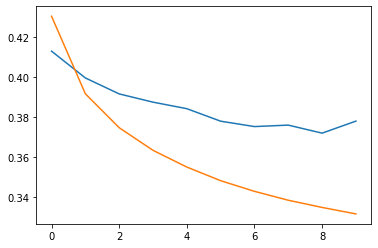

In [27]:
plt.plot(range(10),history.history['val_loss'])
plt.plot(range(10), history.history['loss'])

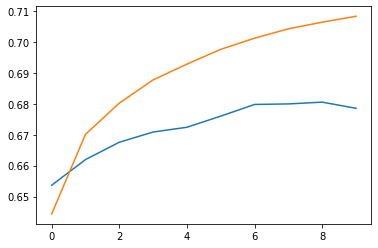

In [28]:
plt.plot(range(10), history.history['val_accuracy'])
plt.plot(range(10), history.history['accuracy'])

### Feature importance

Here we calculate the Breiman permutation importance for each of the model input features. This allows us to assess how much information each input feature is contributing to the resulting predictions from the ML model. 

 - At each step, only one predictor is permuted (randomized)
 - The amount by which the loss function increases when 𝑥 is randomized, is considered the importance of 𝑥
 - If the loss function increases slightly when 𝑥 is permuted, 𝑥 is somewhat important
 - If the loss function explodes when 𝑥 is permuted, 𝑥 is very important
 - If the loss function remains the same or decreases when 𝑥 is permuted, 𝑥 is not important

In [ ]:
feature_names = feature_dict['profile'] + feature_dict['single_level']

In [ ]:
baseline_metric = history.history['val_loss'][-1]
npermutations=10

In [ ]:
permutation_importance = prd_pipeline.calculate_permutation_feature_importance(model, data_splits, feature_dict, baseline_metric, npermutations)

In [ ]:
avg_importance = {}
for k,v in permutation_importance.items():
    avg_importance[k] = np.mean(v)
print(avg_importance)

In [ ]:
df = pd.DataFrame(permutation_importance)
df = df.reindex(columns=[k for k, v in sorted(avg_importance.items(), key=lambda item: item[1])])
df.boxplot(showmeans=True, vert=False)
plt.ylabel('Feature')
plt.xlabel('Change in loss function by permuting feature')
plt.show()

## Inference

In [55]:
y_pred = model.predict(data_splits['X_val'])

pred_column_names = [intensity_band_template.format(source='ml', band_centre=threshold) for threshold in bands.keys()]
y_pred_df = pd.DataFrame(y_pred, columns=pred_column_names)

Calculate cumulative probabilities/fractions

In [155]:
# ml_cumulative_names = [f'ml_cumulative_fraction_exceedance_{upper_bound}mm' for lower_bound, upper_bound in bands.values()]
# y_pred_df[ml_cumulative_names] = 1 - y_pred_df.cumsum(axis=1)

### Model evaluation

In [56]:
evaluation_df = pd.concat([
    data_splits['meta_val'].reset_index(drop=True), 
    data_splits['nwp_val'].reset_index(drop=True), 
    data_splits['y_val'].reset_index(drop=True), 
    y_pred_df], axis=1)

In [57]:
evaluation_df.

,time,realization,latitude,longitude,mogrepsg_fraction_in_band_instant_0.0,mogrepsg_fraction_in_band_instant_0.25,mogrepsg_fraction_in_band_instant_2.5,mogrepsg_fraction_in_band_instant_7.0,mogrepsg_fraction_in_band_instant_10.0,radar_fraction_in_band_instant_0.0,radar_fraction_in_band_instant_0.25,radar_fraction_in_band_instant_2.5,radar_fraction_in_band_instant_7.0,radar_fraction_in_band_instant_10.0,ml_fraction_in_band_instant_0.0,ml_fraction_in_band_instant_0.25,ml_fraction_in_band_instant_2.5,ml_fraction_in_band_instant_7.0,ml_fraction_in_band_instant_10.0
0,2020-02-07 18:00:00,0,49.40625,-5.484375,0.666667,0.222222,0.111111,0.0,0.0,0.463529,0.515294,0.025882,0.0,0.0,0.745663,0.175486,0.075397,0.003224,0.000230
1,2020-02-07 18:00:00,1,49.40625,-5.484375,0.666667,0.222222,0.111111,0.0,0.0,0.463529,0.515294,0.025882,0.0,0.0,0.613238,0.226547,0.156329,0.003752,0.000135
2,2020-02-07 18:00:00,2,49.40625,-5.484375,0.666667,0.222222,0.111111,0.0,0.0,0.463529,0.515294,0.025882,0.0,0.0,0.585044,0.284155,0.127479,0.003184,0.000139
3,2020-02-07 18:00:00,3,49.40625,-5.484375,0.666667,0.222222,0.111111,0.0,0.0,0.463529,0.515294,0.025882,0.0,0.0,0.918390,0.058339,0.019792,0.002534,0.000944
4,2020-02-07 18:00:00,4,49.40625,-5.484375,0.666667,0.222222,0.111111,0.0,0.0,0.463529,0.515294,0.025882,0.0,0.0,0.875504,0.098753,0.025442,0.000294,0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263679,2022-02-21 12:00:00,30,58.78125,-4.359375,1.000000,0.000000,0.000000,0.0,0.0,0.947674,0.040698,0.011628,0.0,0.0,0.909669,0.055295,0.033519,0.001448,0.000070
263680,2022-02-21 12:00:00,31,58.78125,-4.359375,1.000000,0.000000,0.000000,0.0,0.0,0.947674,0.040698,0.011628,0.0,0.0,0.910026,0.055607,0.033716,0.000635,0.000016
263681,2022-02-21 12:00:00,32,58.78125,-4.359375,1.000000,0.000000,0.000000,0.0,0.0,0.947674,0.040698,0.011628,0.0,0.0,0.920395,0.050906,0.027695,0.000950,0.000054
263682,2022-02-21 12:00:00,33,58.78125,-4.359375,1.000000,0.000000,0.000000,0.0,0.0,0.947674,0.040698,0.011628,0.0,0.0,0.927859,0.047747,0.023543,0.000805,0.000046


In [31]:
intensity_bands = [f'{lower_bound}mm-{upper_bound}mm' for lower_bound, upper_bound in bands.values()]
intensity_bands

['0mm-0.01mm', '0.01mm-0.5mm', '0.5mm-4mm', '4mm-10mm', '10mm-220mm']

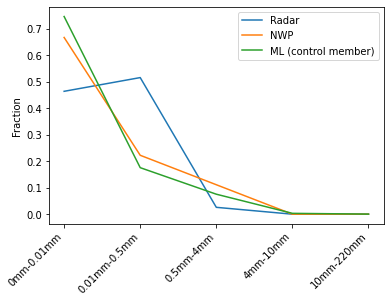

In [32]:
df = evaluation_df[evaluation_df.realization==0]
for i in np.arange(1):
    df.iloc[i][feature_dict['target']].plot(label='Radar')
    df.iloc[i][feature_dict['nwp']].plot(label='NWP')
    df.iloc[i][pred_column_names].plot(label='ML (control member)')
    plt.ylabel('Fraction')
    plt.xticks(np.arange(5), intensity_bands, rotation=45, ha='right')
    plt.legend()
    plt.show()

In [58]:
grouped_df = evaluation_df.groupby(['time', 'latitude', 'longitude'])
grouped_df_mean = grouped_df.agg('mean')

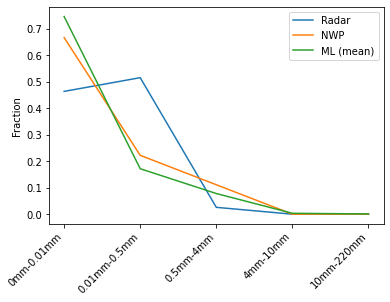

In [34]:
for i in np.arange(1):
    grouped_df_mean.iloc[i][feature_dict['target']].plot(label='Radar')
    grouped_df_mean.iloc[i][feature_dict['nwp']].plot(label='NWP')
    grouped_df_mean.iloc[i][pred_column_names].plot(label='ML (mean)')
    plt.ylabel('Fraction')
    plt.xticks(np.arange(5), intensity_bands,rotation=45, ha='right')
    plt.legend()
    plt.show()

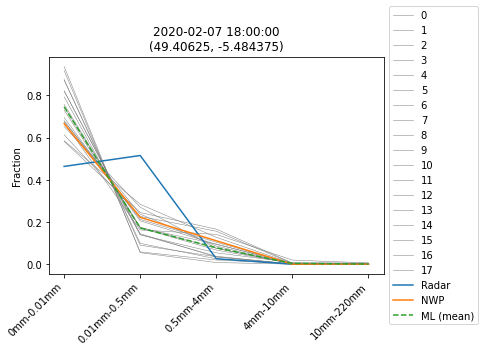

In [35]:
group_keys = list(grouped_df.groups.keys())
for i in np.arange(1):
    evaluation_df.iloc[grouped_df.groups[group_keys[i]]][pred_column_names].T.plot(lw=0.5, color='grey', label='_nolegend_')
    
    grouped_df_mean.iloc[i][feature_dict['target']].plot(label='Radar')
    grouped_df_mean.iloc[i][feature_dict['nwp']].plot(label='NWP')
    grouped_df_mean.iloc[i][pred_column_names].plot(label='ML (mean)', ls='--')
    
    plt.ylabel('Fraction')
    plt.xticks(np.arange(5), intensity_bands, rotation=45, ha='right')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'{group_keys[i][0]}\n{group_keys[i][1:]}')
    
    plt.show()

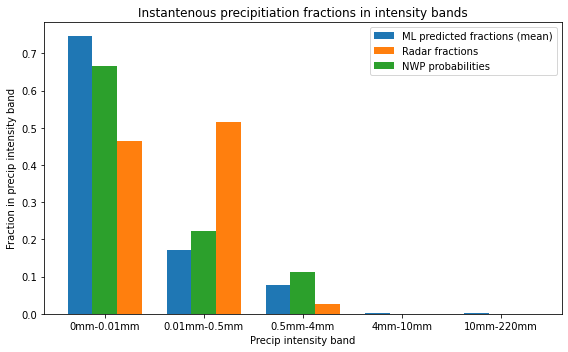

In [36]:
group_keys = list(grouped_df.groups.keys())
for i in np.arange(1):
    x = np.arange(data_dims_dict['nbands'])  # the label locations
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots(figsize=(8,5))
    rects1 = ax.bar(x - width, grouped_df_mean.iloc[i][pred_column_names], width, label='ML predicted fractions (mean)')
    rects2 = ax.bar(x + width, grouped_df_mean.iloc[i][feature_dict['target']], width, label='Radar fractions')
    rects3 = ax.bar(x, grouped_df_mean.iloc[i][feature_dict['nwp']], width, label='NWP probabilities')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Fraction in precip intensity band')
    ax.set_xlabel('Precip intensity band')
    ax.set_title('Instantenous precipitiation fractions in intensity bands')

    plt.xticks(np.arange(5), intensity_bands)
    ax.legend()

    fig.tight_layout()

    plt.show()


Fractional skill score

In [37]:
def calculate_fss(obs, fx):
    """ 
    The inputs to this function are the cumulative probability/fraction of exceeding a given precipitation threshold
    """
    FBS = ((fx - obs)**2).sum()
    FBS_ref = (fx**2).sum() + (obs**2).sum()
    FSS = 1 - (FBS/FBS_ref)
    return FSS

In [80]:
# Calculate FSS - each ensemble member produced ML prediction and treated as deterministic 
for i, col in enumerate(target_parameter):
    y_test = 1 - data_splits['y_val'][target_parameter[:i+1]].sum(axis=1)
    y_test[y_test<0] = 0
    nwp_test = 1 - data_splits['nwp_val'][nwp_comparison[:i+1]].sum(axis=1)
    nwp_test[nwp_test<0]=0
    y_cumulative_pred = 1 - y_pred[:,:i+1].sum(axis=1)
    y_cumulative_pred[y_cumulative_pred<0]=0
    print(f'ML FSS (intensity band {intensity_bands[i]}) {calculate_fss(y_test, y_cumulative_pred):.4f}')
    print(f'NWP FSS (intensity band {intensity_bands[i]}) {calculate_fss(y_test, nwp_test):.4f}')

ML FSS (intensity band 0mm-0.01mm) 0.9150
NWP FSS (intensity band 0mm-0.01mm) 0.8381
ML FSS (intensity band 0.01mm-0.5mm) 0.8557
NWP FSS (intensity band 0.01mm-0.5mm) 0.7424
ML FSS (intensity band 0.5mm-4mm) 0.5353
NWP FSS (intensity band 0.5mm-4mm) 0.1772
ML FSS (intensity band 4mm-10mm) 0.2475
NWP FSS (intensity band 4mm-10mm) 0.0477
ML FSS (intensity band 10mm-220mm) 0.0000
NWP FSS (intensity band 10mm-220mm) 0.0229


In [81]:
# Calculate FSS for mean of ML prediction from set of ens members
grouped = evaluation_df.groupby(['time', 'latitude', 'longitude']).agg('mean')
for i, col in enumerate(target_parameter):
    y_test = 1 - grouped[target_parameter[:i+1]].sum(axis=1)
    y_test[y_test<0] = 0
    nwp_test = 1 - grouped[nwp_comparison[:i+1]].sum(axis=1)
    nwp_test[nwp_test<0]=0
    y_cumulative_pred = 1 - grouped[pred_column_names[:i+1]].sum(axis=1)
    y_cumulative_pred[y_cumulative_pred<0]=0
    print(f'ML FSS (intensity band {intensity_bands[i]}) {calculate_fss(y_test, y_cumulative_pred):.4f}')
    print(f'NWP FSS (intensity band {intensity_bands[i]}) {calculate_fss(y_test, nwp_test):.4f}')

ML FSS (intensity band 0mm-0.01mm) 0.9270
NWP FSS (intensity band 0mm-0.01mm) 0.8381
ML FSS (intensity band 0.01mm-0.5mm) 0.8799
NWP FSS (intensity band 0.01mm-0.5mm) 0.7424
ML FSS (intensity band 0.5mm-4mm) 0.5694
NWP FSS (intensity band 0.5mm-4mm) 0.1772
ML FSS (intensity band 4mm-10mm) 0.2580
NWP FSS (intensity band 4mm-10mm) 0.0477
ML FSS (intensity band 10mm-220mm) 0.0000
NWP FSS (intensity band 10mm-220mm) 0.1195


# Plot of FSS on map

In [47]:
def fss_for_grid(df, model, feature_dict, data_dims_dict):
    X_test_df, y_test_df, nwp_test_df, meta_test = prd_pipeline.load_test_data(df, feature_dict, data_dims_dict)

    ypred_test_df = model.predict(X_test_df)
    
    # calculate cumulative probabilities  - WHY DOES THIS NOT WORK??
    y_pred_cdf = 1 - ypred_test_df.cumsum(axis=1)
    y_pred_cdf[y_pred_cdf<0]=0  # Some cumulative fractions sum to just over 1 due to rounding error

    y_test_cdf = 1 - y_test_df.cumsum(axis=1)
    y_test_cdf[y_test_cdf<0]=0  # Some cumulative fractions sum to just over 1 due to rounding error

    nwp_test_cdf = 1 - nwp_test_df.cumsum(axis=1)
    nwp_test_cdf[nwp_test_cdf<0]=0  # Some cumulative fractions sum to just over 1 due to rounding error
    
    # calculative fractional skill score 
    ml_fss, nwp_fss = [], [] 
    for i, col in enumerate(feature_dict['target']):
        # ml_fss.append(calculate_fss(y_test_cdf.iloc[:,i], y_pred_cdf[:,i]))
        # nwp_fss.append(calculate_fss(y_test_cdf.iloc[:,i], nwp_test_cdf.iloc[:,i]))
        
        ml = y_pred_cdf[:,i]
        nwp = nwp_test_cdf.iloc[:,i]
        radar = y_test_cdf.iloc[:,i]

#         radar = radar[ml > 0]
#         nwp = nwp[ml > 0]
#         ml = ml[ml > 0]

#         radar = radar[nwp > 0]
#         ml = ml[nwp > 0]
#         nwp = nwp[nwp > 0]

        ml_fss.append(calculate_fss(radar, ml))
        nwp_fss.append(calculate_fss(radar, nwp))
    
    ml_fss_names = ['_'.join(['ml_fss'] + [name.split('_')[-1]]) for name in feature_dict['target']]
    nwp_fss_names = ['_'.join(['nwp_fss'] + [name.split('_')[-1]]) for name in feature_dict['target']]
    
    return pd.concat([pd.Series(ml_fss, index=ml_fss_names), pd.Series(nwp_fss, index=nwp_fss_names)])

In [75]:
# To calculate FSS of fraction predicted by ML model treating each ensemble members as deterministic
fss_grid = merged_df.groupby(['latitude', 'longitude']).apply(lambda x: fss_for_grid(x, model, feature_dict, data_dims_dict))

/tmp/ipykernel_9072/2480169759.py:7: RuntimeWarning: invalid value encountered in double_scalars
  FSS = 1 - (FBS/FBS_ref)
/tmp/ipykernel_9072/2480169759.py:7: RuntimeWarning: invalid value encountered in double_scalars
  FSS = 1 - (FBS/FBS_ref)
/tmp/ipykernel_9072/2480169759.py:7: RuntimeWarning: invalid value encountered in double_scalars
  FSS = 1 - (FBS/FBS_ref)
/tmp/ipykernel_9072/2480169759.py:7: RuntimeWarning: invalid value encountered in double_scalars
  FSS = 1 - (FBS/FBS_ref)
/tmp/ipykernel_9072/2480169759.py:7: RuntimeWarning: invalid value encountered in double_scalars
  FSS = 1 - (FBS/FBS_ref)
/tmp/ipykernel_9072/2480169759.py:7: RuntimeWarning: invalid value encountered in double_scalars
  FSS = 1 - (FBS/FBS_ref)
/tmp/ipykernel_9072/2480169759.py:7: RuntimeWarning: invalid value encountered in double_scalars
  FSS = 1 - (FBS/FBS_ref)
/tmp/ipykernel_9072/2480169759.py:7: RuntimeWarning: invalid value encountered in double_scalars
  FSS = 1 - (FBS/FBS_ref)
/tmp/ipykernel_9

In [ ]:
# To calculate FSS of mean fraction predicted by ML model for ensemble members from same model run
# grid_grouped_df = merged_df.groupby(['time', 'latitude', 'longitude']).agg('mean').reset_index()
# fss_grid = grid_grouped_df.groupby(['latitude', 'longitude']).apply(lambda x: fss_for_grid(x, model, feature_dict, data_dims_dict))

In [ ]:
# To calculate FSS of mean fraction predicted by ML model for ensemble members from same model run
fss_grid = merged_df[merged_df.realization==0].groupby(['latitude', 'longitude']).apply(lambda x: fss_for_grid(x, model, feature_dict, data_dims_dict))

In [94]:
fss_grid.head()

ml_fss_0.0  ml_fss_0.25    ml_fss_2.5    ml_fss_7.0  \
latitude longitude                                                        
49.40625 -5.484375    0.494149     0.383878  4.952355e-01  3.351100e-01   
         -5.203125    0.789384     0.418435  1.891080e-01  1.504640e-01   
         -4.921875    0.731704     0.398012  5.394523e-01 -4.239869e-08   
         -4.640625    0.755880     0.302224 -2.117216e-08 -4.331868e-08   
         -4.359375    0.822501     0.478136  1.678182e-08 -2.851410e-08   

                     ml_fss_10.0  nwp_fss_0.0  nwp_fss_0.25  nwp_fss_2.5  \
latitude longitude                                                         
49.40625 -5.484375  0.000000e+00     0.291094      0.054829          0.0   
         -5.203125  0.000000e+00     0.486303      0.013258          0.0   
         -4.921875  0.000000e+00     0.592905      0.021182          0.0   
         -4.640625  1.889640e-10     0.678326      0.047303          0.0   
         -4.359375  2.342950e-10     0.933376      0.208676          0.0   

                    nwp_fss_7.0  nwp_fss_10.0  
latitude longitude                             
49.40625 -5.484375          0.0           NaN  
         -5.203125          0.0           NaN  
         -4.921875          NaN           NaN  
         -4.640625          0.0           0.0  
         -4.359375          0.0           0.0

In [ ]:
fss_grid.to_csv('fss_ml_control_pred.csv')

# Test scenario predictions and model performance assessment

In [38]:
nwp_fractions = [
    test_scenario.groupby(['latitude', 'longitude', 'time'])[['rainfall_rate']].apply(
        lambda x: calc_nwp_probabilities(x, lower_bound, upper_bound)).rename(columns={'rainfall_rate':intensity_band_template.format(source='mogrepsg', band_centre=intensity_band)})
    for intensity_band, [lower_bound, upper_bound] in bands.items()]
nwp_prob_df = pd.concat(nwp_fractions, axis=1)
test_scenario = pd.merge(test_scenario, nwp_prob_df, left_on=['latitude', 'longitude', 'time'], right_index=True)

In [71]:
X_test_df, y_test_df, nwp_test_df, meta_test = prd_pipeline.load_test_data(test_scenario, feature_dict, data_dims_dict)
ypred_test = model.predict(X_test_df)
ypred_test_df = pd.DataFrame(ypred_test, columns=pred_column_names)

In [74]:
test_scenario_evaluation_df = pd.concat([meta_test, ypred_test_df, y_test_df, nwp_test_df], axis=1)

In [124]:
test_scenario_evaluation_df.to_csv('test_scenario_fractions_data.csv')

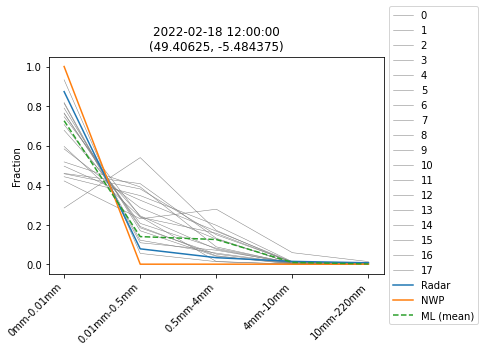

In [132]:
grouped_df = test_scenario_evaluation_df.groupby(['time', 'latitude', 'longitude'])
grouped_df_mean = grouped_df.agg('mean')
group_keys = list(grouped_df.groups.keys())
for i in np.arange(1):
    evaluation_df.iloc[grouped_df.groups[group_keys[i]]][pred_column_names].T.plot(lw=0.5, color='grey', label='_nolegend_')
    
    grouped_df_mean.iloc[i][feature_dict['target']].plot(label='Radar')
    grouped_df_mean.iloc[i][feature_dict['nwp']].plot(label='NWP')
    grouped_df_mean.iloc[i][pred_column_names].plot(label='ML (mean)', ls='--')
    
    plt.ylabel('Fraction')
    plt.xticks(np.arange(5), intensity_bands, rotation=45, ha='right')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'{group_keys[i][0]}\n{group_keys[i][1:]}')
    
    plt.show()

Calculate FSS on unseen data

In [53]:
fss_grid = test_scenario.groupby(['latitude', 'longitude']).apply(lambda x: fss_for_grid(x, model, feature_dict, data_dims_dict))

In [93]:
fss_grid.head()

ml_fss_0.0  ml_fss_0.25    ml_fss_2.5    ml_fss_7.0  \
latitude longitude                                                        
49.40625 -5.484375    0.494149     0.383878  4.952355e-01  3.351100e-01   
         -5.203125    0.789384     0.418435  1.891080e-01  1.504640e-01   
         -4.921875    0.731704     0.398012  5.394523e-01 -4.239869e-08   
         -4.640625    0.755880     0.302224 -2.117216e-08 -4.331868e-08   
         -4.359375    0.822501     0.478136  1.678182e-08 -2.851410e-08   

                     ml_fss_10.0  nwp_fss_0.0  nwp_fss_0.25  nwp_fss_2.5  \
latitude longitude                                                         
49.40625 -5.484375  0.000000e+00     0.291094      0.054829          0.0   
         -5.203125  0.000000e+00     0.486303      0.013258          0.0   
         -4.921875  0.000000e+00     0.592905      0.021182          0.0   
         -4.640625  1.889640e-10     0.678326      0.047303          0.0   
         -4.359375  2.342950e-10     0.933376      0.208676          0.0   

                    nwp_fss_7.0  nwp_fss_10.0  
latitude longitude                             
49.40625 -5.484375          0.0           NaN  
         -5.203125          0.0           NaN  
         -4.921875          NaN           NaN  
         -4.640625          0.0           0.0  
         -4.359375          0.0           0.0

In [51]:
fss_grid.to_csv('fss_ml_det_pred_test_scenario_seen.csv')